In [86]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [151]:
import json
import numpy as np

def precision(actual, predicted):
    actual_set = set(actual)
    return (
        sum(1.0 for p in predicted if p in actual_set) / float(len(predicted))
        if len(predicted)
        else 1.0
    )


def recall(actual, predicted):
    if len(actual) == 0:
        return 1.0

    actual_set = set(actual)
    return (
        sum(1.0 for p in predicted if p in actual_set) / float(len(actual))
        if len(actual)
        else 1.0
    )


def f1(actual, predicted):
    pr = precision(actual, predicted)
    rec = recall(actual, predicted)

    return 2.0 * pr * rec / (pr + rec) if (pr + rec > 0.0) else 0.0


def parse(answer):
    if answer == "[NULL_ANSWER]":
        return None
    return [a.strip() for a in answer.split("[LIST]")]


def single_score(actual, predicted, query_type):

        
    
    if query_type in {"min", "max"}:
        if actual is None and predicted is None:
            return 1.0

        if actual is not None and predicted is None:
            return 0.0

        if predicted is not None and actual is None:
            return 0.0
    
        return 1.0 if predicted[0] == actual[0] else 0.0

    elif query_type in {"argmin", "argmax", "set", "set_complex_ok", "set_complex_none", "argmin_complex_ok","argmin_complex_none","argmax_complex_ok","argmax_complex_none"}:
        return f1(set(actual if actual is not None else []),set(predicted if predicted is not None else []))

    elif query_type in {"count","count_complex_ok","count_complex_none"}:
        if predicted is None or len(predicted) > 1:
            return 0.0

        return 1.0 if predicted[0] == actual[0] else 0.0
    elif query_type in {"bool", "bool_complex_ok", "bool_complex_none"}:
        if predicted is None and actual is None:
            return 1.0
        else:
            if isinstance(actual, list) and isinstance(predicted, list):
                if len(actual) == 1 and len(predicted) == 1:
                    return 1.0 if predicted[0] == actual[0] else 0.0

            return 0.0

    return 0.0


0 1
1 2
2 5
5 10
10 20
Total 0.916444559082454
Num instances 9384
Total 0.9157869575927343
Num instances 18768
Total 0.9160575786645095
Num instances 28152


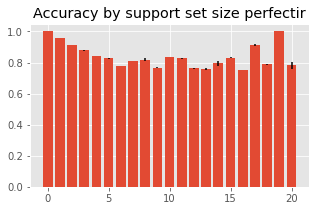

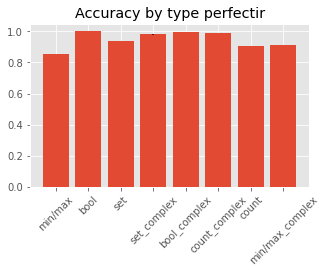

Total 0.8784276851608647
Num instances 37536
Total 0.855876072402389
Num instances 46920
Total 0.8405964143275767
Num instances 56304


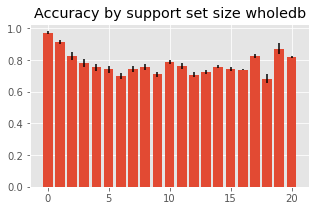

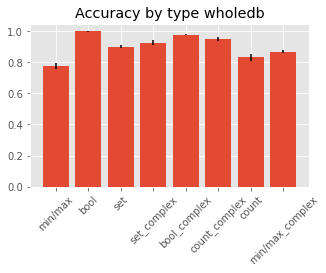

Total 0.8072302448744655
Num instances 62296


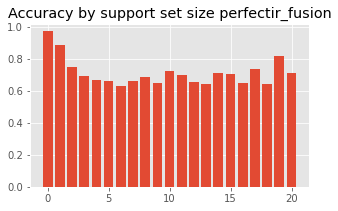

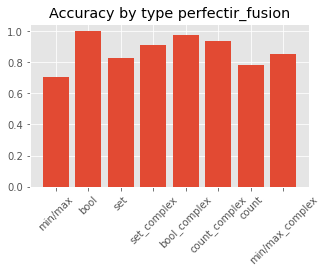

Total 0.759971938662695
Num instances 68288


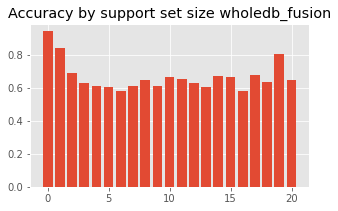

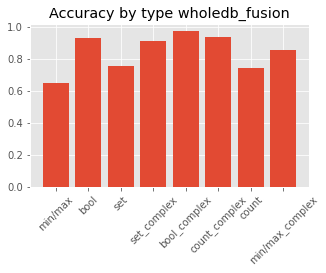

In [159]:
breakdown = []
raw = []

seeds = [1,2,3]

all_system_size = dict()
all_system_type = dict()
all_system_bins = dict()


ranges = [0,1,2,5,10,20]
bins = dict()
for idx,r in enumerate(ranges[:-1]):
    print(ranges[idx],ranges[idx+1])
    for item in list(range(ranges[idx],ranges[idx+1])):
        bins[item] = (ranges[idx],ranges[idx+1])
bins[20] = (20)
    

systems = ["perfectir","wholedb", "perfectir_fusion", "wholedb_fusion"]
for system in systems:
    master_breakdown_size = defaultdict(list)
    master_breakdown_type = defaultdict(list)
    master_breakdown_bins = defaultdict(list)

    for seed in seeds:
        if os.path.exists(f"checkpoint/experiment={system}/db=v1.8_25,lr=1e-4/seed-{seed}/metrics_test.json"):
            with open(f"checkpoint/experiment={system}/db=v1.8_25,lr=1e-4/seed-{seed}/metrics_test.json") as f:

                for line in f:
                    instance = json.loads(line)["test"]
                    raw.extend(instance["raw"])
        elif os.path.exists(f"checkpoint/experiment={system}/db=v1.6_25,lr=1e-4/seed-{seed}/metrics_test.json"):
            with open(f"checkpoint/experiment={system}/db=v1.6_25,lr=1e-4/seed-{seed}/metrics_test.json") as f:

                for line in f:
                    instance = json.loads(line)["test"]
                    raw.extend(instance["raw"])
        else:
            continue
                
        breakdown = defaultdict(list)
        breakdown_size = defaultdict(list)
        breakdown_bins = defaultdict(list)

        ss = defaultdict(list)
        total_scores = list()

        for i in range(0,21):
            breakdown_size[i]=[]

        for predicted,actual, _,_ ,metadata in raw:

            predicted = parse(predicted)
            actual = parse(actual)

            local_score = single_score(actual, predicted, metadata["query_type"])
            breakdown[metadata["query_type"].replace("arg","").replace("min","mmx").replace("max","mmx").replace("mmx","min/max").replace("_ok","").replace("_none","")].append(local_score)

            ss[metadata["query_type"]].append(len(metadata["query"]["gold_facts"]))
            breakdown_size[len(metadata["query"]["gold_facts"]) if len(metadata["query"]["gold_facts"]) < 20 else 20].append(local_score)
            breakdown_bins[bins[len(metadata["query"]["gold_facts"])  if len(metadata["query"]["gold_facts"]) < 20 else 20]].append(local_score)            
            total_scores.append(local_score)

        for k,v in breakdown_size.items():
            master_breakdown_size[k].append(np.mean(v))

        for k,v in breakdown.items():
            master_breakdown_type[k].append(np.mean(v))  
            
        for k,v in breakdown_bins.items():
            master_breakdown_bins[k].append(np.mean(v))  
            
        print("Total", np.mean(total_scores))
        print("Num instances", len(total_scores))
        
    all_system_type[system] = master_breakdown_type
    all_system_size[system] = master_breakdown_size
    all_system_bins[system] = master_breakdown_bins


    plt.title(f"Accuracy by support set size {system}")
    plt.bar(list(master_breakdown_size.keys()), list(np.mean(k) for k in master_breakdown_size.values()),yerr=list(np.std(k) for k in master_breakdown_size.values()))
    plt.show()

    plt.title(f"Accuracy by type {system}")
    plt.bar(list(master_breakdown_type.keys()), list(np.mean(k) for k in master_breakdown_type.values()),yerr=list(np.std(k) for k in master_breakdown_type.values()))

    plt.xticks(rotation=45)
    plt.show()




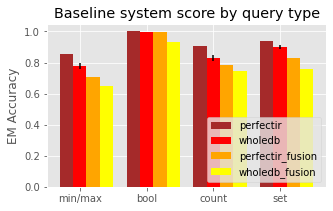

In [160]:
plt.style.use('ggplot')

labels = ['min/max','min/max_complex', 'bool', 'bool_complex', 'count', 'count_complex', 'set', 'set_complex']
labels = ['min/max', 'bool', 'count', 'set']
plt.rcParams["figure.figsize"] = (5,3)
scores = []
for system in systems:
    score = []
    for label in labels:
        score.append(all_system_type[system][label])

    scores.append(score)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
ptr = -1*len(systems)*width/2+width

colors = ["brown","red","orange","yellow"]

for color, score, system in zip(colors,scores,systems):
    rects1 = ax.bar(x + ptr, [np.mean(s) for s in score], width, color=color, yerr=[np.std(s) for s in score], label=system)
    ptr += width
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EM Accuracy')
ax.set_title('Baseline system score by query type')
plt.xticks(x,rotation=0)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
plt.savefig("baseline_type.pdf")

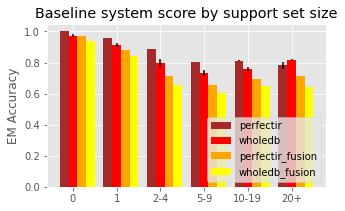

In [161]:
plt.style.use('ggplot')

ranges = [0,1,2,5,10,20]
labels = ["0","1","2-4","5-9","10-19","20+"]
s_bins = []
for idx,r in enumerate(ranges[:-1]):
    s_bins.append((ranges[idx],ranges[idx+1]))
    
s_bins.append(20)
plt.rcParams["figure.figsize"] = (5,3)
scores = []
for system in systems:
    score = []
    for sbin in s_bins:
        local = []
        score.append(all_system_bins[system][sbin])

    scores.append(score)
    

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
ptr = -1*len(systems)*width/2+width

colors = ["brown","red","orange","yellow"]

for color, score, system in zip(colors,scores,systems):
    rects1 = ax.bar(x + ptr, [np.mean(s) for s in score], width, color=color, yerr=[np.std(s) for s in score], label=system)
    ptr += width
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EM Accuracy')
ax.set_title('Baseline system score by support set size')
plt.xticks(x,rotation=0)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
plt.savefig("baseline_size.pdf")